# **1. Setting up all the paths**

In [1]:
import os

In [2]:
CUSTOM_MODEL_NAME = 'erd_detection' 
PRETRAINED_MODEL_NAME = 'ssd_mobilenet_v1_fpn_640x640_coco17_tpu-8'
PRETRAINED_MODEL_URL = 'http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_mobilenet_v1_fpn_640x640_coco17_tpu-8.tar.gz'
TF_RECORD_SCRIPT_NAME = 'generate_tfrecord.py'
LABEL_MAP_NAME = 'label_map.pbtxt'

In [3]:
paths = {
    'WORKSPACE_PATH': os.path.join('Tensorflow', 'workspace'),
    'SCRIPTS_PATH': os.path.join('Tensorflow','scripts'),
    'APIMODEL_PATH': os.path.join('Tensorflow','models'),
    'ANNOTATION_PATH': os.path.join('Tensorflow', 'workspace','annotations'),
    'IMAGE_PATH': os.path.join('Tensorflow', 'workspace','images'),
    'MODEL_PATH': os.path.join('Tensorflow', 'workspace','models'),
    'PRETRAINED_MODEL_PATH': os.path.join('Tensorflow', 'workspace','pre-trained-models'),
    'CHECKPOINT_PATH': os.path.join('Tensorflow', 'workspace','models',CUSTOM_MODEL_NAME), 
    'OUTPUT_PATH': os.path.join('Tensorflow', 'workspace','models',CUSTOM_MODEL_NAME, 'export'), 
    'TFJS_PATH':os.path.join('Tensorflow', 'workspace','models',CUSTOM_MODEL_NAME, 'tfjsexport'), 
    'TFLITE_PATH':os.path.join('Tensorflow', 'workspace','models',CUSTOM_MODEL_NAME, 'tfliteexport'), 
    'PROTOC_PATH':os.path.join('Tensorflow','protoc')
 }

In [4]:
files = {
    'PIPELINE_CONFIG':os.path.join('Tensorflow', 'workspace','models', CUSTOM_MODEL_NAME, 'pipeline.config'),
    'TF_RECORD_SCRIPT': os.path.join(paths['SCRIPTS_PATH'], TF_RECORD_SCRIPT_NAME), 
    'LABELMAP': os.path.join(paths['ANNOTATION_PATH'], LABEL_MAP_NAME)
}

In [5]:
# The labels we will be detecting (mainly want the objects, cardinalities are optional)
labels = ['entity', 'weak_entity', 'rel', 'ident_rel', 'rel_attr', 'many', 'one']

In [6]:
for path in paths.values():
    if not os.path.exists(path):
        if os.name == 'posix':
            !mkdir -p {path}
        if os.name == 'nt':
            !mkdir {path}

In [7]:
if os.name=='nt':
    !pip install wget
    import wget

# **2. Downloading the TF Models**

In [8]:
if not os.path.exists(os.path.join(paths['APIMODEL_PATH'], 'research', 'object_detection')):
    !git clone https://github.com/tensorflow/models {paths['APIMODEL_PATH']}

Cloning into 'Tensorflow/models'...
remote: Enumerating objects: 78544, done.
remote: Counting objects: 100% (347/347), done.
remote: Compressing objects: 100% (202/202), done.
remote: Total 78544 (delta 171), reused 292 (delta 144), pack-reused 78197
Receiving objects: 100% (78544/78544), 593.72 MiB | 16.71 MiB/s, done.
Resolving deltas: 100% (55794/55794), done.


In [9]:
# Install Tensorflow Object Detection 
if os.name=='posix':  
    !apt-get install protobuf-compiler
    !cd Tensorflow/models/research && protoc object_detection/protos/*.proto --python_out=. && cp object_detection/packages/tf2/setup.py . && python -m pip install . 
    
if os.name=='nt':
    url="https://github.com/protocolbuffers/protobuf/releases/download/v3.15.6/protoc-3.15.6-win64.zip"
    wget.download(url)
    !move protoc-3.15.6-win64.zip {paths['PROTOC_PATH']}
    !cd {paths['PROTOC_PATH']} && tar -xf protoc-3.15.6-win64.zip
    os.environ['PATH'] += os.pathsep + os.path.abspath(os.path.join(paths['PROTOC_PATH'], 'bin'))   
    !cd Tensorflow/models/research && protoc object_detection/protos/*.proto --python_out=. && copy object_detection\\packages\\tf2\\setup.py setup.py && python setup.py build && python setup.py install
    !cd Tensorflow/models/research/slim && pip install -e . 

Reading package lists... Done
Building dependency tree       
Reading state information... Done
protobuf-compiler is already the newest version (3.0.0-9.1ubuntu1).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 4 not upgraded.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Processing /content/Tensorflow/models/research
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
     |████████████████████████████████| 11.0 MB 48.7 MB/s 
     |███████████████████████████████

In [10]:
VERIFICATION_SCRIPT = os.path.join(paths['APIMODEL_PATH'], 'research', 'object_detection', 'builders', 'model_builder_tf2_test.py')
# Verify Installation
!python {VERIFICATION_SCRIPT}

2022-11-07 03:10:44.914346: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-07 03:10:45.092140: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-11-07 03:10:45.929862: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
2022-11-07 03:10:45.930042: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open 

In [11]:
import object_detection

In [12]:
if os.name =='posix':
    !wget {PRETRAINED_MODEL_URL}
    !mv {PRETRAINED_MODEL_NAME+'.tar.gz'} {paths['PRETRAINED_MODEL_PATH']}
    !cd {paths['PRETRAINED_MODEL_PATH']} && tar -zxvf {PRETRAINED_MODEL_NAME+'.tar.gz'}
if os.name == 'nt':
    wget.download(PRETRAINED_MODEL_URL)
    !move {PRETRAINED_MODEL_NAME+'.tar.gz'} {paths['PRETRAINED_MODEL_PATH']}
    !cd {paths['PRETRAINED_MODEL_PATH']} && tar -zxvf {PRETRAINED_MODEL_NAME+'.tar.gz'}

--2022-11-07 03:16:53--  http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_mobilenet_v1_fpn_640x640_coco17_tpu-8.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 142.251.10.128, 2404:6800:4003:c0f::80
Connecting to download.tensorflow.org (download.tensorflow.org)|142.251.10.128|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 90453990 (86M) [application/x-tar]
Saving to: ‘ssd_mobilenet_v1_fpn_640x640_coco17_tpu-8.tar.gz’

ssd_mobilenet_v1_fp 100%[===================>]  86.26M  36.2MB/s    in 2.4s    

2022-11-07 03:16:56 (36.2 MB/s) - ‘ssd_mobilenet_v1_fpn_640x640_coco17_tpu-8.tar.gz’ saved [90453990/90453990]

ssd_mobilenet_v1_fpn_640x640_coco17_tpu-8/
ssd_mobilenet_v1_fpn_640x640_coco17_tpu-8/checkpoint/
ssd_mobilenet_v1_fpn_640x640_coco17_tpu-8/checkpoint/ckpt-0.data-00000-of-00001
ssd_mobilenet_v1_fpn_640x640_coco17_tpu-8/checkpoint/checkpoint
ssd_mobilenet_v1_fpn_640x640_coco17_tpu-8/checkpoint/ckpt-0.index
ssd_mo

# **3. Create Label Map**

In [13]:
labels = [{'name':'entity', 'id':1}, {'name':'weak_entity', 'id':2}, {'name':'rel', 'id':3}, {'name':'ident_rel', 'id':4}, {'name': 'rel_attr', 'id':5}, {'name': 'many', 'id':6}, {'name': 'one', 'id':7}]
with open(files['LABELMAP'], 'w') as f:
    for label in labels:
        f.write('item { \n')
        f.write('\tname:\'{}\'\n'.format(label['name']))
        f.write('\tid:{}\n'.format(label['id']))
        f.write('}\n')

# **4. Creating TF records**

In [14]:
if not os.path.exists(files['TF_RECORD_SCRIPT']):
    !git clone https://github.com/nicknochnack/GenerateTFRecord {paths['SCRIPTS_PATH']}

Cloning into 'Tensorflow/scripts'...
remote: Enumerating objects: 3, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 3 (delta 0), reused 1 (delta 0), pack-reused 0
Unpacking objects: 100% (3/3), done.


In [15]:
!python {files['TF_RECORD_SCRIPT']} -x {os.path.join(paths['IMAGE_PATH'], 'train')} -l {files['LABELMAP']} -o {os.path.join(paths['ANNOTATION_PATH'], 'train.record')} 
!python {files['TF_RECORD_SCRIPT']} -x {os.path.join(paths['IMAGE_PATH'], 'test')} -l {files['LABELMAP']} -o {os.path.join(paths['ANNOTATION_PATH'], 'test.record')} 

2022-11-07 03:17:15.266071: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
Successfully created the TFRecord file: Tensorflow/workspace/annotations/train.record
2022-11-07 03:17:18.513015: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
Successfully created the TFRecord file: Tensorflow/workspace/annotations/test.record


# **5. Copying Model Config to Training Folder**

In [16]:
if os.name =='posix':
    !cp {os.path.join(paths['PRETRAINED_MODEL_PATH'], PRETRAINED_MODEL_NAME, 'pipeline.config')} {os.path.join(paths['CHECKPOINT_PATH'])}
if os.name == 'nt':
    !copy {os.path.join(paths['PRETRAINED_MODEL_PATH'], PRETRAINED_MODEL_NAME, 'pipeline.config')} {os.path.join(paths['CHECKPOINT_PATH'])}

# **6. Updating the config file for our case / requirements**

In [17]:
import tensorflow as tf
from object_detection.utils import config_util
from object_detection.protos import pipeline_pb2
from google.protobuf import text_format

In [18]:
config = config_util.get_configs_from_pipeline_file(files['PIPELINE_CONFIG'])


In [19]:
pipeline_config = pipeline_pb2.TrainEvalPipelineConfig()
with tf.io.gfile.GFile(files['PIPELINE_CONFIG'], "r") as f:                                                                                                                                                                                                                     
    proto_str = f.read()                                                                                                                                                                                                                                          
    text_format.Merge(proto_str, pipeline_config)  

In [20]:
pipeline_config.model.ssd.num_classes = len(labels)
pipeline_config.train_config.batch_size = 4
pipeline_config.train_config.fine_tune_checkpoint = os.path.join(paths['PRETRAINED_MODEL_PATH'], PRETRAINED_MODEL_NAME, 'checkpoint', 'ckpt-0')
pipeline_config.train_config.fine_tune_checkpoint_type = "detection"
pipeline_config.train_input_reader.label_map_path= files['LABELMAP']
pipeline_config.train_input_reader.tf_record_input_reader.input_path[:] = [os.path.join(paths['ANNOTATION_PATH'], 'train.record')]
pipeline_config.eval_input_reader[0].label_map_path = files['LABELMAP']
pipeline_config.eval_input_reader[0].tf_record_input_reader.input_path[:] = [os.path.join(paths['ANNOTATION_PATH'], 'test.record')]

In [21]:
config_text = text_format.MessageToString(pipeline_config)                                                                                                                                                                                                        
with tf.io.gfile.GFile(files['PIPELINE_CONFIG'], "wb") as f:                                                                                                                                                                                                                     
    f.write(config_text)

# **7. Training the model**

In [22]:
TRAINING_SCRIPT = os.path.join(paths['APIMODEL_PATH'], 'research', 'object_detection', 'model_main_tf2.py')


In [23]:
command = "python {} --model_dir={} --pipeline_config_path={} --num_train_steps=4000".format(TRAINING_SCRIPT, paths['CHECKPOINT_PATH'],files['PIPELINE_CONFIG'])


In [24]:
print(command)


python Tensorflow/models/research/object_detection/model_main_tf2.py --model_dir=Tensorflow/workspace/models/erd_detection --pipeline_config_path=Tensorflow/workspace/models/erd_detection/pipeline.config --num_train_steps=4000


In [25]:
# This will run our model. We can see the loss function as we step through
!{command}

2022-11-07 03:17:50.807757: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-11-07 03:17:51.561361: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
2022-11-07 03:17:51.561473: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
2022-11-07 03:17:51.561493: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed p

# **7. Loading trained model from checkpoint**

In [26]:
import os
import tensorflow as tf
tf.config.run_functions_eagerly(True)
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.builders import model_builder
from object_detection.utils import config_util

In [27]:
# Load pipeline config and build a detection model
configs = config_util.get_configs_from_pipeline_file(files['PIPELINE_CONFIG'])
detection_model = model_builder.build(model_config=configs['model'], is_training=False)

# Restore checkpoint
ckpt = tf.compat.v2.train.Checkpoint(model=detection_model)
ckpt.restore(os.path.join(paths['CHECKPOINT_PATH'], 'ckpt-5')).expect_partial()

@tf.function
def detect_fn(image):
    image, shapes = detection_model.preprocess(image)
    prediction_dict = detection_model.predict(image, shapes)
    detections = detection_model.postprocess(prediction_dict, shapes)
    return detections

# **8. Doing detection from an image passed in**

In [28]:
import cv2 
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure

%matplotlib inline

In [29]:
category_index = label_map_util.create_category_index_from_labelmap(files['LABELMAP'])


In [55]:
IMAGE_PATH = '/content/Tensorflow/workspace/images/test/028.png'


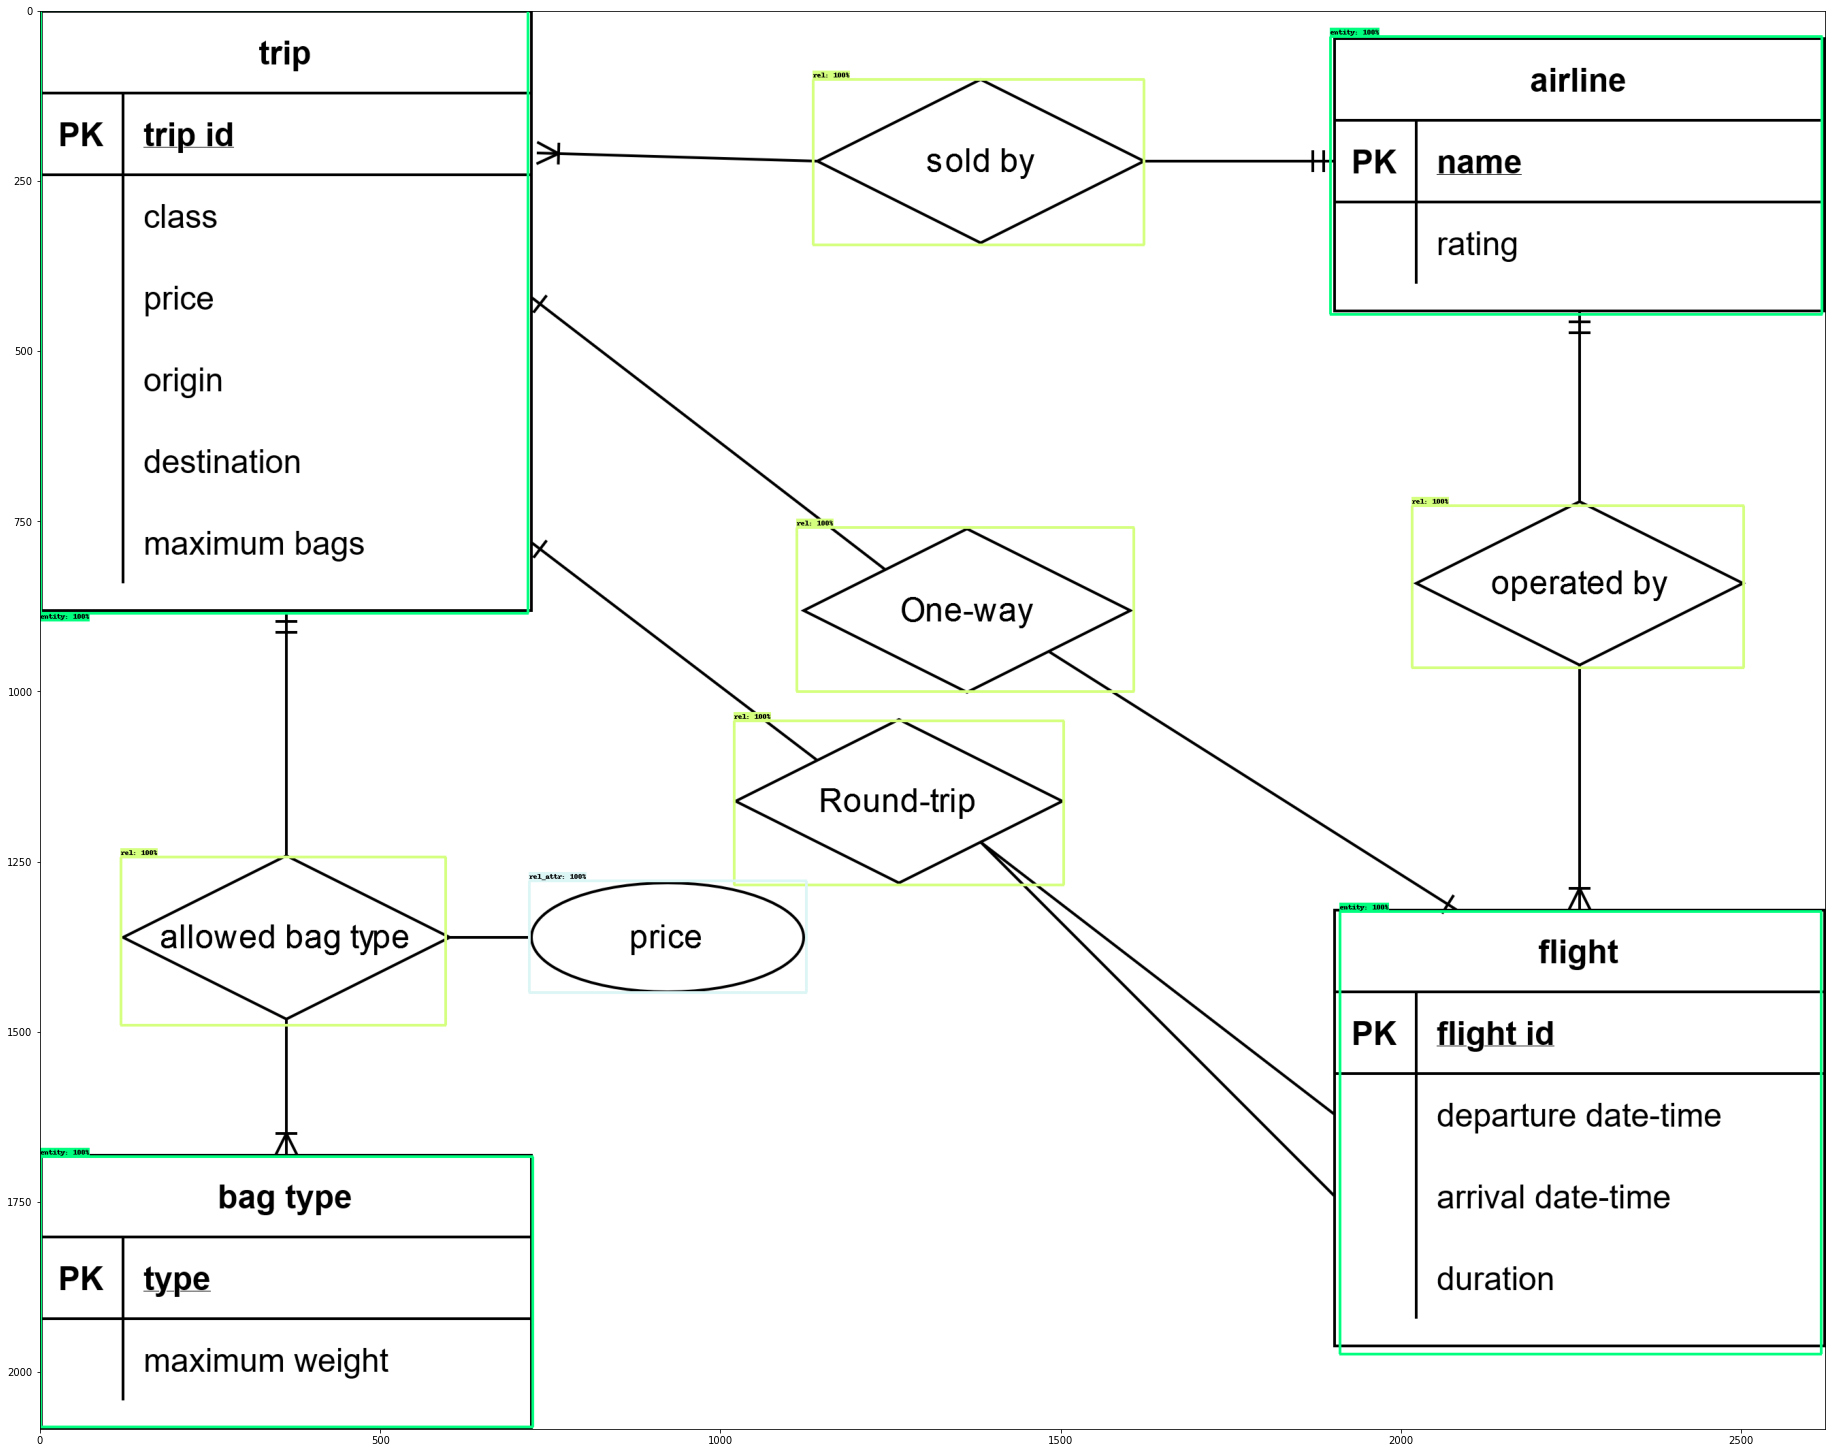

In [56]:
img = cv2.imread(IMAGE_PATH)
image_np = np.array(img)

input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)
detections = detect_fn(input_tensor)


num_detections = int(detections.pop('num_detections'))
detections = {key: value[0, :num_detections].numpy()
              for key, value in detections.items()}
detections['num_detections'] = num_detections

# detection_classes should be ints.
detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

label_id_offset = 1
image_np_with_detections = image_np.copy()

viz_utils.visualize_boxes_and_labels_on_image_array(
            image_np_with_detections,
            detections['detection_boxes'],
            detections['detection_classes']+label_id_offset,
            detections['detection_scores'],
            category_index,
            use_normalized_coordinates=True,
            min_score_thresh=.6,
            agnostic_mode=False)

# This is showcasing the image 
plt.imshow(cv2.cvtColor(image_np_with_detections, cv2.COLOR_BGR2RGB))
figure = plt.gcf()

# The following is for personal use so I can see the image better (can remove later)
figure.set_size_inches(32, 32)
figure.savefig('boxed_image.png', dpi=100)
plt.show()

# **9. Outputting the coordinates and labels of detections**

In [57]:
# Here, I am trying to output the coordinates of the detections with the labels associated 
boxes = np.squeeze(detections['detection_boxes'])
classes = np.squeeze(detections['detection_classes'])

scores = np.squeeze(detections['detection_scores'])
#set a min thresh score, say 0.8
min_score_thresh = 0.5
bboxes = boxes[scores > min_score_thresh]


#get image size
h, w, c = img.shape
im_width, im_height = w, h
#print(im_width, im_height)
final_box = []
i = 0
#print(classes)
labels = [{'name':'entity', 'id':1}, {'name':'weak_entity', 'id':2}, {'name':'rel', 'id':3}, {'name':'ident_rel', 'id':4}, {'name': 'rel_attr', 'id':5}, {'name': 'many', 'id':6}, {'name': 'one', 'id':7}]
output = []
for box in bboxes:
    ymin, xmin, ymax, xmax = box
    #arr.append(labels[classes[i]]['name'])
    #arr.append((xmin * im_width, xmax * im_width, ymin * im_height, ymax * im_height))
    x = (labels[classes[i]]['name'], (xmin * im_width, xmax * im_width, ymin * im_height, ymax * im_height))
    output.append(x)
    #print(labels[classes[i]]['name'])
    #print(xmin * im_width, xmax * im_width, ymin * im_height, ymax * im_height)
    i = i + 1


In [58]:
# ['<object>', (xmin, xmax, ymin, ymax)]
for item in output:
  print(item)

('entity', (1909.4065856933594, 2617.8317947387695, 1324.5237593650818, 1973.7154989242554))
('rel', (1019.1646976470947, 1504.8043518066406, 1044.132169008255, 1284.068942308426))
('rel', (2015.4731903076172, 2503.631317138672, 728.3017311096191, 965.50488114357))
('rel', (1135.1250953674316, 1622.2553443908691, 102.8795225173235, 344.13238847255707))
('rel', (118.34766817092896, 596.7547779083252, 1244.8823714256287, 1490.4930868148804))
('rel', (1111.5350494384766, 1607.0872650146484, 760.6016383171082, 1000.6688385009766))
('entity', (0.0, 724.0448226928711, 1684.041365146637, 2080.0432209968567))
('entity', (1895.1800498962402, 2618.7171897888184, 39.557355880737305, 446.09652388095856))
('entity', (0.0, 717.8501853942871, 0.8308503031730652, 885.4015336036682))
('rel_attr', (718.197790145874, 1126.6501865386963, 1279.564370393753, 1442.038008928299))


In [40]:
# If you want to tar the model
!tar -czf models.tar.gz {paths['CHECKPOINT_PATH']}

In [59]:
f = open('module_1_coordinates.txt', 'w')
for t in output:
    f.write(str(t) + '\n')
f.close()